In [3]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

In [4]:
tf.reset_default_graph()

In [5]:
num_samples=100000

[ 0.11823482  0.22853026  0.69337451 ...,  0.82990378  0.09876705
  0.54068148]
[ 0.31379906  0.30336612  0.34736515 ...,  0.37139359  0.30503631
  0.36336568]


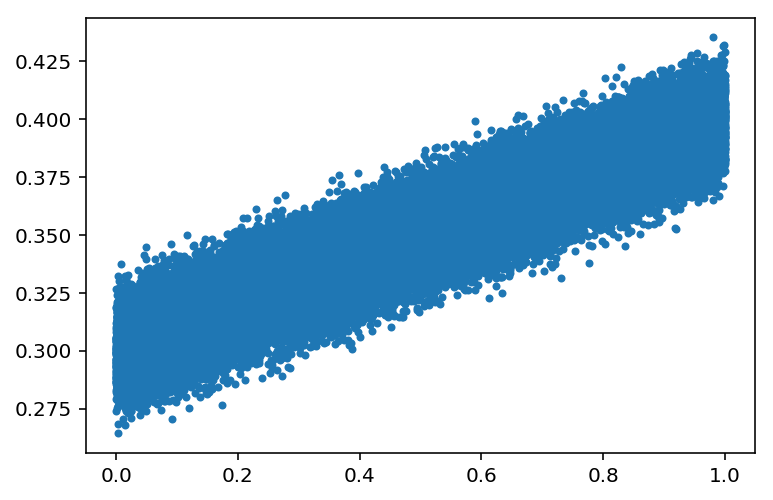

In [6]:
# 1.2 Create input data using NumPy. y = x * 0.1 + 0.3 + noise
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

# Pplot our input data.
pylab.plot(x_train, y_train, '.')

[ 0.84340787  0.44725105  0.97230011 ...,  0.99991882  0.26195893
  0.95845491]
[ 0.38949702  0.34583572  0.39776959 ...,  0.41922206  0.32532711
  0.38900767]


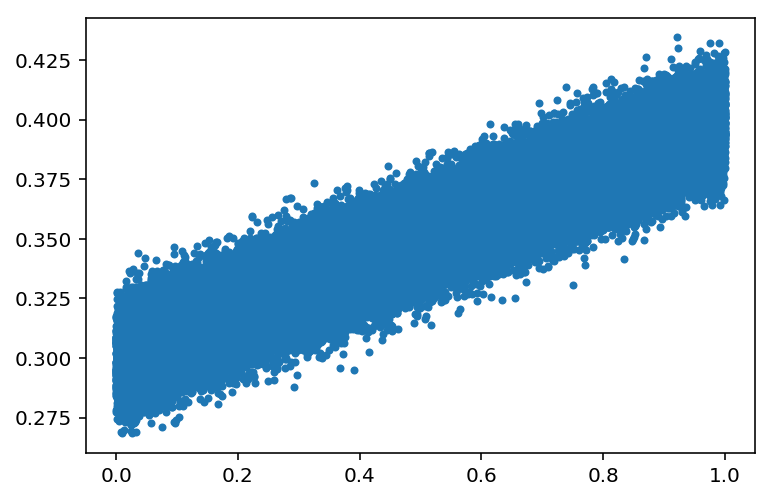

In [7]:
# Create some fake test/validation data
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [ ]:
jit_scope = tf.contrib.compiler.jit.experimental_jit_scope

In [ ]:
# 1.3 Build inference graph.
# Create Variables W and b that compute y = W * x + b
with tf.device("/cpu:0"):
  W = tf.get_variable(shape=[], name='weights')
  print(W)

  b = tf.get_variable(shape=[], name='bias')
  print(b)

  # Create a placeholder we'll use later to feed x's into the graph for training and test.
  # shape=[None] means we can put in any number of examples. 
  # This is used for minibatch training, and to evaluate a lot of examples at once.
  x_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='x_observed')
  print(x_observed)

with tf.device("/device:XLA_GPU:0"):
#  with jit_scope():
    # Same as tf.add(tf.matmul(W, tf.transpose(x)), b)
    y_pred = W * x_observed + b
    print(y_pred)

In [ ]:
# Write the graph so we can look at it in TensorBoard
# Now is a good time to try that
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/xla/%s/train' % version, graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/xla/%s/test' % version, graph=tf.get_default_graph())

print(version)

In [ ]:
# 1.4 Build training graph.
# Create an operation that calculates loss.

# Create a placeholder we'll use later to feed the correct y value into the graph
with tf.device("/device:XLA_GPU:0"):
#  with jit_scope():
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))

    # Create an optimizer.
    optimizer_op = tf.train.GradientDescentOptimizer(0.025)  

    # Create an operation that minimizes loss.
    train_op = optimizer_op.minimize(loss_op)  

    # 'loss', 'optimizer' and 'train' are.
    print("loss:", loss_op)
    print("optimizer:", optimizer_op)
    print("train:", train_op)

In [ ]:
# Create an operation to initialize all the variables.
with tf.device("/cpu:0"):
  init_op = tf.global_variables_initializer()
  print(init_op)

In [ ]:
config = tf.ConfigProto(
  log_device_placement=True,
  #device_count={'CPU':1, 'GPU': 1}
)

config.gpu_options.allow_growth=True
#config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1

print(config)

In [ ]:
sess = tf.Session(config=config)
sess.run(init_op)

print(sess.run(W))
print(sess.run(b))

## Accuracy of Random Weights

In [ ]:
# Convenience method for evaluating the loss (error)
def test(x, y):
  return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [ ]:
# Calculate accuracy on the test data using random initial values for y
# Note:  This should be relatively far from 0 since we haven't yet trained the model
test(x=x_test, y=y_test)

In [ ]:
# Add a Summary Operation so we can visualize the loss in TensorBoard
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

# Train Model

In [ ]:
%%time

max_steps = 2000

run_metadata = tf.RunMetadata()

for step in range(max_steps):
  # Run the training op; feed the training data into the graph
  if (step < max_steps):
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
  else:  
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), run_metadata=run_metadata)
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
    with open('xla-timeline.json', 'w') as trace_file:
      trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

# The following take a relatively long time, so do them at periodic intervals
  if step % 1000 == 0:
    print(step, sess.run([W, b]))
    train_summary_writer.add_summary(train_summary_log, step)
    train_summary_writer.flush()
    test_summary_writer.add_summary(test_summary_log, step)
    test_summary_writer.flush()

In [ ]:
# Plot the predicted values
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, feed_dict={x_observed: x_train, y_observed: y_train}), ".", label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

In [ ]:
# Check accuracy on eval data after training
# Note:  This should be close to 0!
test(x=x_test, y=y_test)

In [ ]:
#https://github.com/tensorflow/serving/blob/master/tensorflow_serving/example/mnist_saved_model.py

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat

# Save the model
export_path = "/root/models/linear/xla/%s" % version
with tf.device("/cpu:0"):
  builder = saved_model_builder.SavedModelBuilder(export_path)
  print(export_path)

###################################################
# Re-Run the Notebook from the Top if you see the following error: 
#
#  "Export directory already exists. Please specify a different export directory"
###################################################

In [ ]:
tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

In [ ]:
prediction_signature =  signature_def_utils.build_signature_def(inputs = {'x_observed': tensor_info_x_observed}, outputs = {'y_pred': tensor_info_y_pred}, method_name = signature_constants.PREDICT_METHOD_NAME)            

builder.add_meta_graph_and_variables(sess, 
                                     [tag_constants.SERVING],
                                     signature_def_map={'predict':prediction_signature,
                                                        signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}
                                    )

In [ ]:
builder.save()

## Save the Model in Previous Format
We will use this later.

In [ ]:
from tensorflow.python.framework import graph_io
graph_io.write_graph(sess.graph, "/root/models/optimize_me/", "unoptimized_gpu.pb")